# PCA Applications: Data Compression and Feature Extraction

**Author**: Nelson Masbayi

---

In this notebook, we explore practical applications of PCA, focusing on data compression and feature extraction for machine learning. We'll analyze trade-offs between compression ratio and quality, and demonstrate PCA's value in real-world scenarios.

## Table of Contents

1. [Data Compression with PCA](#data-compression-with-pca)
2. [Image Compression Analysis](#image-compression-analysis)
3. [Compression Quality Metrics](#compression-quality-metrics)
4. [Trade-off Analysis](#trade-off-analysis)
5. [Practical Compression Guidelines](#practical-compression-guidelines)

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import sys
import os
import pickle
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Add src directory to the path
sys.path.append('../src')
from visualization_utils import plot_reconstruction_analysis

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# Set random seed
np.random.seed(42)

print("✅ All imports successful!")
print("🎯 Ready for PCA compression analysis")

✅ All imports successful!
🎯 Ready for PCA compression analysis


## Data Compression with PCA

PCA enables lossy data compression by:
1. **Dimensionality reduction**: Keep only the most important components
2. **Information preservation**: Retain maximum variance with fewer dimensions
3. **Reconstruction**: Approximate original data from compressed representation

### Compression Pipeline
```
Original Data → PCA Transform → Reduced Data → Storage/Transmission → PCA Inverse → Reconstructed Data
```

In [17]:
# Define compression utility functions
def calculate_compression_ratio(original_shape, n_components):
    """
    Calculate the compression ratio for PCA.

    For PCA compression, we need to store:
    - Transformed data: n_samples × n_components
    - Components: n_components × n_features
    - Mean vector: n_features
    """
    n_samples, n_features = original_shape

    # Original data size
    original_size = n_samples * n_features

    # Compressed data size
    transformed_size = n_samples * n_components  # Transformed data
    components_size = n_components * n_features  # Principal components
    mean_size = n_features                       # Mean vector

    compressed_size = transformed_size + components_size + mean_size

    compression_ratio = original_size / compressed_size

    return compression_ratio, original_size, compressed_size

def calculate_quality_metrics(original, reconstructed):
    """
    Calculate various quality metrics for reconstruction.
    """
    # Mean Squared Error
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Peak Signal-to-Noise Ratio (PSNR)
    if mse == 0:
        psnr = float('inf')
    else:
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / rmse)

    # Structural Similarity (simplified version)
    # Correlation coefficient as a simple similarity measure
    correlation = np.corrcoef(original.flatten(), reconstructed.flatten())[0, 1]

    return {
        'mse': mse,
        'rmse': rmse,
        'psnr': psnr,
        'correlation': correlation
    }

def compress_and_reconstruct(data, n_components):
    """
    Compress data using PCA and reconstruct it.
    """
    # Fit PCA
    pca = PCA(n_components=n_components)

    # Transform (compress)
    start_time = time.time()
    compressed_data = pca.fit_transform(data)
    compression_time = time.time() - start_time

    # Inverse transform (reconstruct)
    start_time = time.time()
    reconstructed_data = pca.inverse_transform(compressed_data)
    reconstruction_time = time.time() - start_time

    return pca, compressed_data, reconstructed_data, compression_time, reconstruction_time

print("Compression utility functions defined!")
print("Functions available:")
print("• calculate_compression_ratio()")
print("• calculate_quality_metrics()")
print("• compress_and_reconstruct()")

Compression utility functions defined!
Functions available:
• calculate_compression_ratio()
• calculate_quality_metrics()
• compress_and_reconstruct()


## Image Compression Analysis

Let's start with face image compression using the Olivetti faces dataset:

Loading Olivetti Faces dataset for compression analysis...
Dataset loaded successfully!
Shape: (400, 4096)
Image dimensions: 64×64 pixels
Data range: [0.000, 1.000]

Dataset Statistics:
Number of samples: 400
Number of features: 4096
Memory usage: 6400.0 KB


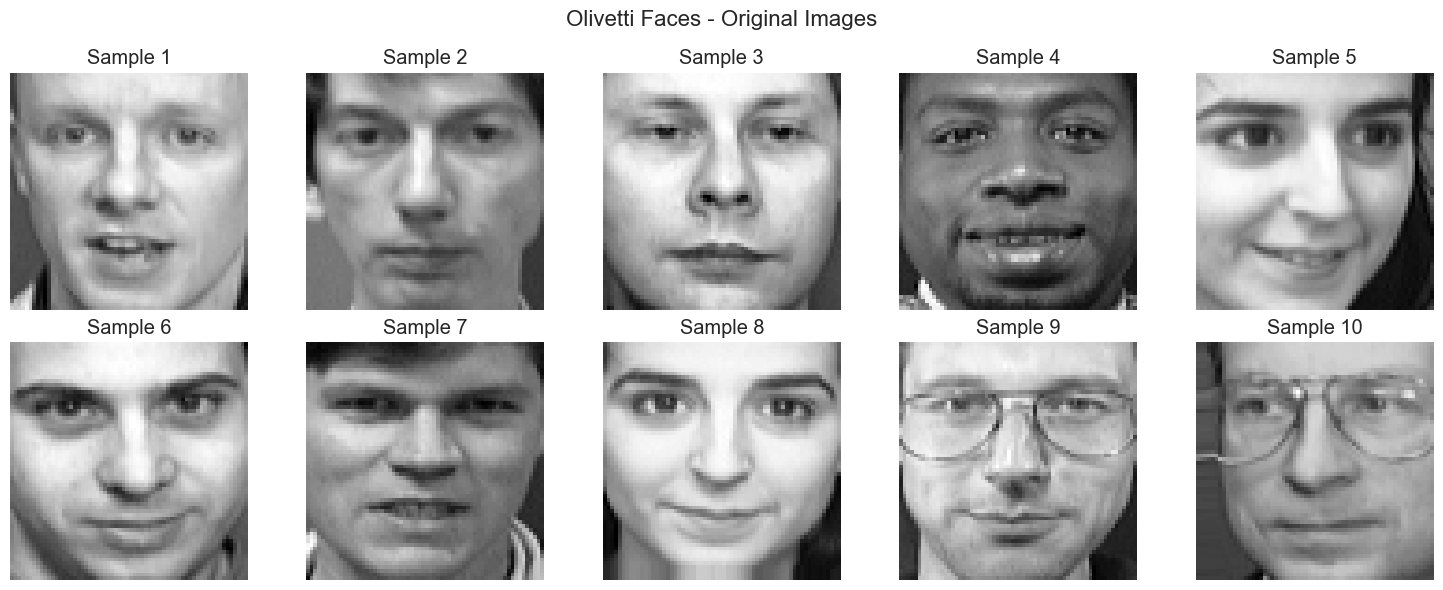

In [18]:
# Load face data
print("Loading Olivetti Faces dataset for compression analysis...")

try:
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    X_faces = faces.data
    y_faces = faces.target

    print(f"Dataset loaded successfully!")
    print(f"Shape: {X_faces.shape}")
    print(f"Image dimensions: 64×64 pixels")
    print(f"Data range: [{X_faces.min():.3f}, {X_faces.max():.3f}]")

    faces_available = True

except Exception as e:
    print(f"Error loading faces: {e}")
    print("Using MNIST digits as backup for compression analysis")

    digits = load_digits()
    X_faces = digits.data
    y_faces = digits.target

    print(f"MNIST digits shape: {X_faces.shape}")
    print(f"Image dimensions: 8×8 pixels")

    faces_available = False

# Basic dataset statistics
print(f"\nDataset Statistics:")
print(f"Number of samples: {X_faces.shape[0]}")
print(f"Number of features: {X_faces.shape[1]}")
print(f"Memory usage: {X_faces.nbytes / 1024:.1f} KB")

# Display sample images
img_dim = 64 if faces_available else 8
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    image = X_faces[i].reshape(img_dim, img_dim)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

dataset_name = "Olivetti Faces" if faces_available else "MNIST Digits"
plt.suptitle(f'{dataset_name} - Original Images', fontsize=16)
plt.tight_layout()
plt.show()

In [19]:
# Comprehensive compression analysis
print("\n" + "="*60)
print("COMPREHENSIVE COMPRESSION ANALYSIS")
print("="*60)

# Define component ranges to test
if faces_available:
    component_ranges = [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]
else:
    component_ranges = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50]

# Remove components that exceed feature count
max_components = min(X_faces.shape[1], X_faces.shape[0])
component_ranges = [c for c in component_ranges if c <= max_components]

print(f"Testing component ranges: {component_ranges}")
print(f"Maximum possible components: {max_components}")

# Storage for results
results = {
    'n_components': [],
    'compression_ratio': [],
    'variance_explained': [],
    'mse': [],
    'rmse': [],
    'psnr': [],
    'correlation': [],
    'compression_time': [],
    'reconstruction_time': [],
    'original_size': [],
    'compressed_size': []
}

print("\nProcessing compression analysis...")

for i, n_comp in enumerate(component_ranges):
    print(f"\rProcessing {n_comp} components ({i+1}/{len(component_ranges)})...", end='')

    # Compress and reconstruct
    pca, compressed, reconstructed, comp_time, recon_time = compress_and_reconstruct(X_faces, n_comp)

    # Calculate compression ratio
    comp_ratio, orig_size, comp_size = calculate_compression_ratio(X_faces.shape, n_comp)

    # Calculate quality metrics
    quality = calculate_quality_metrics(X_faces, reconstructed)

    # Store results
    results['n_components'].append(n_comp)
    results['compression_ratio'].append(comp_ratio)
    results['variance_explained'].append(np.sum(pca.explained_variance_ratio_))
    results['mse'].append(quality['mse'])
    results['rmse'].append(quality['rmse'])
    results['psnr'].append(quality['psnr'])
    results['correlation'].append(quality['correlation'])
    results['compression_time'].append(comp_time)
    results['reconstruction_time'].append(recon_time)
    results['original_size'].append(orig_size)
    results['compressed_size'].append(comp_size)

print(" ✅ Complete!")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print(f"\nCompression Analysis Summary:")
print(f"Components tested: {len(component_ranges)}")
print(f"Best compression ratio: {max(results['compression_ratio']):.1f}x")
print(f"Highest PSNR: {max([p for p in results['psnr'] if p != float('inf')]):.1f} dB")
print(f"Best correlation: {max(results['correlation']):.4f}")


COMPREHENSIVE COMPRESSION ANALYSIS
Testing component ranges: [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]
Maximum possible components: 400

Processing compression analysis...
Processing 200 components (13/13)... ✅ Complete!

Compression Analysis Summary:
Components tested: 13
Best compression ratio: 190.7x
Highest PSNR: 33.9 dB
Best correlation: 0.9931


## Compression Quality Metrics

Analysis of the relationship between compression and quality:

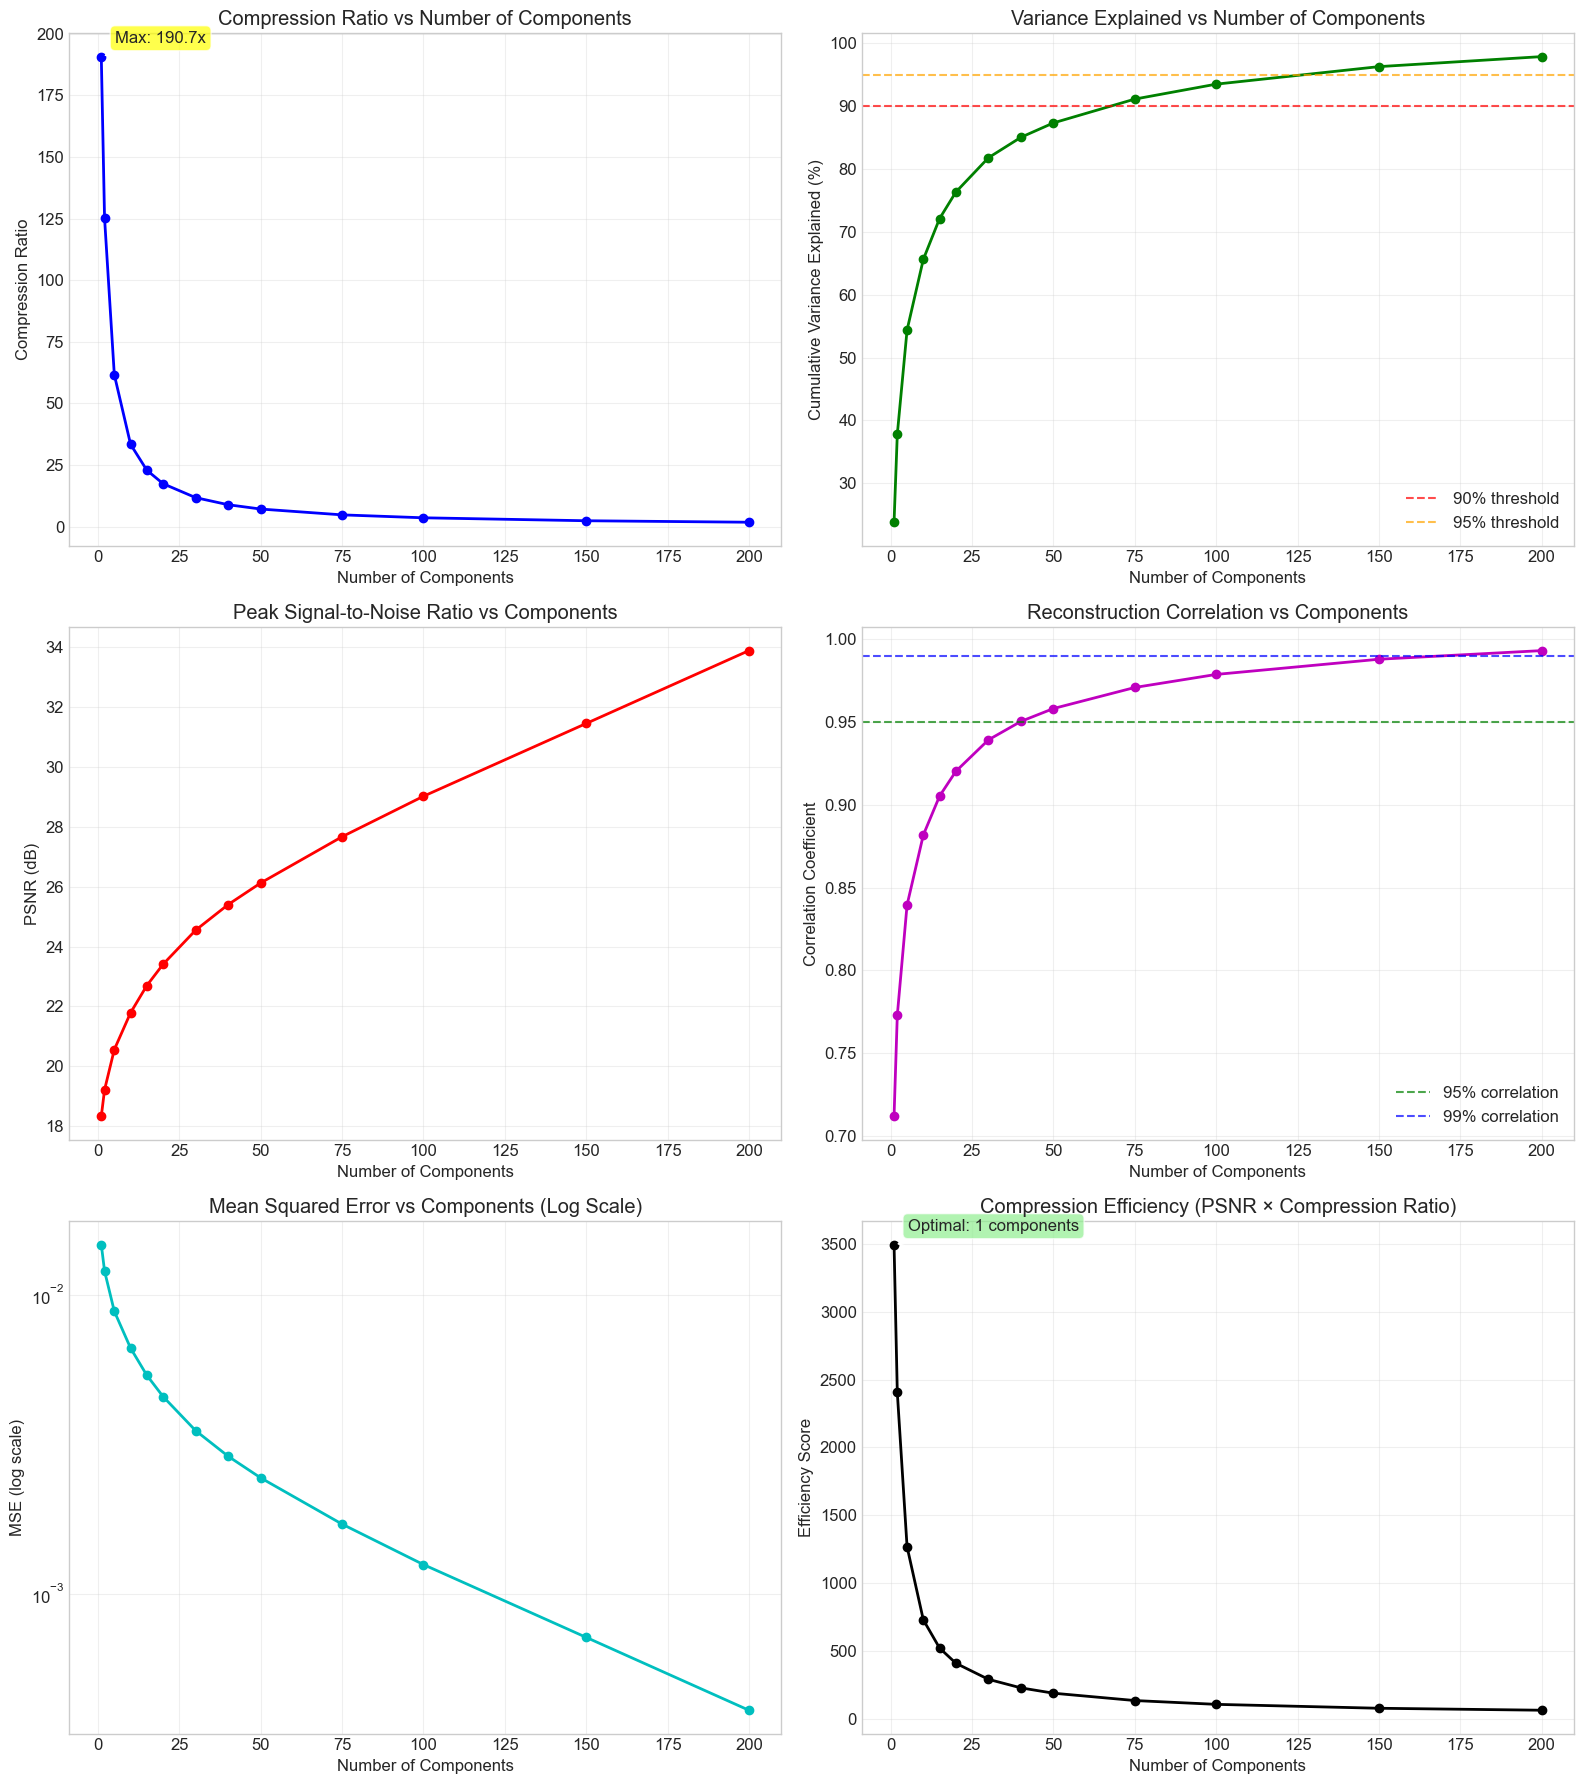


KEY COMPRESSION FINDINGS
Optimal Configuration:
• Components: 1
• Compression ratio: 190.7x
• Variance explained: 23.8%
• PSNR: 18.3 dB
• Correlation: 0.7119

Storage Savings:
• Original size: 12800.0 KB
• Compressed size: 67.1 KB
• Space saved: 12732.9 KB (99.5%)


In [20]:
# Create comprehensive quality analysis plots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Compression Ratio vs Components
axes[0, 0].plot(results['n_components'], results['compression_ratio'], 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_title('Compression Ratio vs Number of Components')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Compression Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Add annotations for key points
max_compression_idx = np.argmax(results['compression_ratio'])
axes[0, 0].annotate(f'Max: {results["compression_ratio"][max_compression_idx]:.1f}x',
                   xy=(results['n_components'][max_compression_idx], results['compression_ratio'][max_compression_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 2. Variance Explained vs Components
axes[0, 1].plot(results['n_components'], np.array(results['variance_explained'])*100, 'go-', linewidth=2, markersize=6)
axes[0, 1].axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90% threshold')
axes[0, 1].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
axes[0, 1].set_title('Variance Explained vs Number of Components')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. PSNR vs Components
psnr_finite = [p if p != float('inf') else max([x for x in results['psnr'] if x != float('inf')])
               for p in results['psnr']]
axes[1, 0].plot(results['n_components'], psnr_finite, 'ro-', linewidth=2, markersize=6)
axes[1, 0].set_title('Peak Signal-to-Noise Ratio vs Components')
axes[1, 0].set_xlabel('Number of Components')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Correlation vs Components
axes[1, 1].plot(results['n_components'], results['correlation'], 'mo-', linewidth=2, markersize=6)
axes[1, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% correlation')
axes[1, 1].axhline(y=0.99, color='blue', linestyle='--', alpha=0.7, label='99% correlation')
axes[1, 1].set_title('Reconstruction Correlation vs Components')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Correlation Coefficient')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. MSE vs Components (log scale)
axes[2, 0].semilogy(results['n_components'], results['mse'], 'co-', linewidth=2, markersize=6)
axes[2, 0].set_title('Mean Squared Error vs Components (Log Scale)')
axes[2, 0].set_xlabel('Number of Components')
axes[2, 0].set_ylabel('MSE (log scale)')
axes[2, 0].grid(True, alpha=0.3)

# 6. Compression Efficiency (Quality per Compression)
# Define efficiency as PSNR / (1/compression_ratio)
efficiency = [psnr * comp_ratio for psnr, comp_ratio in zip(psnr_finite, results['compression_ratio'])]
axes[2, 1].plot(results['n_components'], efficiency, 'ko-', linewidth=2, markersize=6)
axes[2, 1].set_title('Compression Efficiency (PSNR × Compression Ratio)')
axes[2, 1].set_xlabel('Number of Components')
axes[2, 1].set_ylabel('Efficiency Score')
axes[2, 1].grid(True, alpha=0.3)

# Find optimal efficiency point
optimal_idx = np.argmax(efficiency)
axes[2, 1].annotate(f'Optimal: {results["n_components"][optimal_idx]} components',
                   xy=(results['n_components'][optimal_idx], efficiency[optimal_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Print key findings
print("\n" + "="*50)
print("KEY COMPRESSION FINDINGS")
print("="*50)

optimal_components = results['n_components'][optimal_idx]
optimal_compression = results['compression_ratio'][optimal_idx]
optimal_variance = results['variance_explained'][optimal_idx] * 100
optimal_psnr = psnr_finite[optimal_idx]
optimal_correlation = results['correlation'][optimal_idx]

print(f"Optimal Configuration:")
print(f"• Components: {optimal_components}")
print(f"• Compression ratio: {optimal_compression:.1f}x")
print(f"• Variance explained: {optimal_variance:.1f}%")
print(f"• PSNR: {optimal_psnr:.1f} dB")
print(f"• Correlation: {optimal_correlation:.4f}")

print(f"\nStorage Savings:")
original_kb = results['original_size'][0] * 8 / 1024  # Convert to KB (assuming 8 bytes per float)
compressed_kb = results['compressed_size'][optimal_idx] * 8 / 1024
print(f"• Original size: {original_kb:.1f} KB")
print(f"• Compressed size: {compressed_kb:.1f} KB")
print(f"• Space saved: {original_kb - compressed_kb:.1f} KB ({(1-compressed_kb/original_kb)*100:.1f}%)")

## Trade-off Analysis

I have created visualizations to understand the trade-offs between compression and quality:


COMPRESSION vs QUALITY TRADE-OFF ANALYSIS


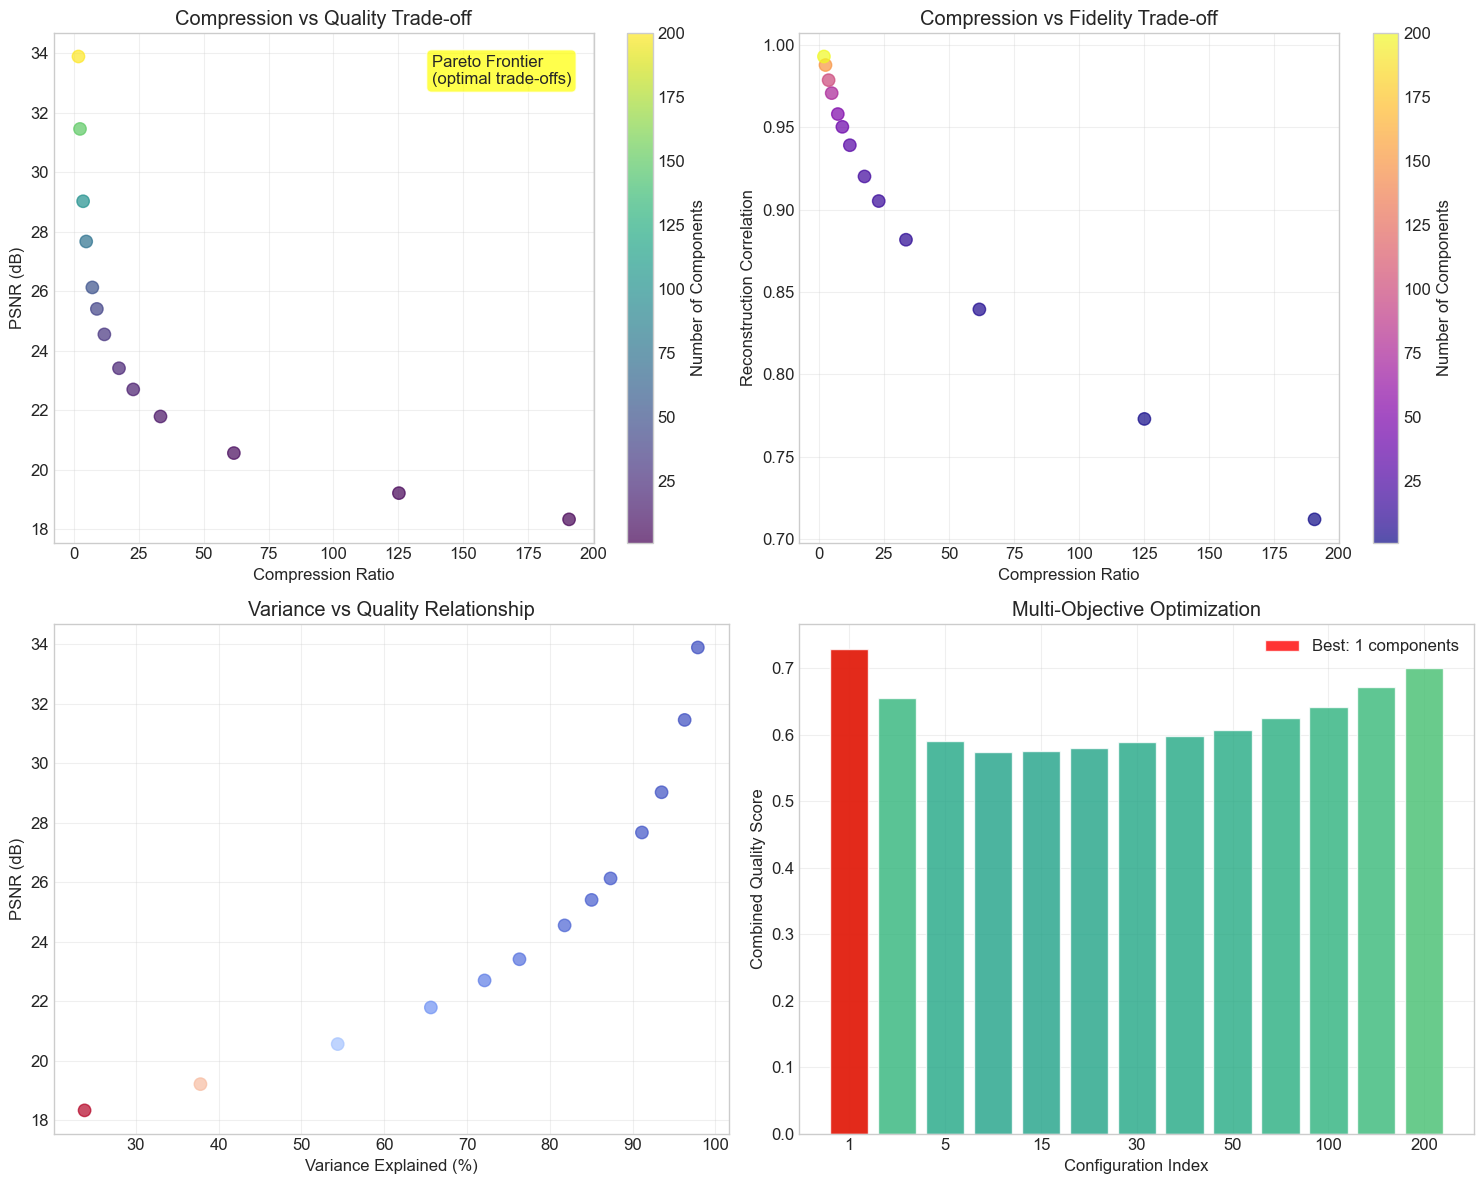


Multi-Objective Analysis:
Best combined score: 1 components
• Compression: 190.7x
• PSNR: 18.3 dB
• Correlation: 0.7119
• Variance explained: 23.8%

COMPRESSION CATEGORIES

High Compression:
• Components: 1-1
• Avg compression: 190.7x
• Avg PSNR: 18.3 dB
• Use case: Storage/transmission

Balanced:
• Components: 2-2
• Avg compression: 125.2x
• Avg PSNR: 19.2 dB
• Use case: General purpose

High Quality:
• Components: 5-200
• Avg compression: 16.0x
• Avg PSNR: 26.1 dB
• Use case: Analysis/visualization


In [21]:
# Create trade-off analysis
print("\n" + "="*50)
print("COMPRESSION vs QUALITY TRADE-OFF ANALYSIS")
print("="*50)

# Create trade-off plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Compression Ratio vs PSNR
scatter1 = axes[0, 0].scatter(results['compression_ratio'], psnr_finite,
                             c=results['n_components'], cmap='viridis', s=80, alpha=0.7)
axes[0, 0].set_xlabel('Compression Ratio')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('Compression vs Quality Trade-off')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Number of Components')

# Add pareto frontier annotation
axes[0, 0].annotate('Pareto Frontier\n(optimal trade-offs)',
                   xy=(0.7, 0.9), xycoords='axes fraction',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 2. Compression Ratio vs Correlation
scatter2 = axes[0, 1].scatter(results['compression_ratio'], results['correlation'],
                             c=results['n_components'], cmap='plasma', s=80, alpha=0.7)
axes[0, 1].set_xlabel('Compression Ratio')
axes[0, 1].set_ylabel('Reconstruction Correlation')
axes[0, 1].set_title('Compression vs Fidelity Trade-off')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Number of Components')

# 3. Variance Explained vs PSNR
axes[1, 0].scatter(np.array(results['variance_explained'])*100, psnr_finite,
                  c=results['compression_ratio'], cmap='coolwarm', s=80, alpha=0.7)
axes[1, 0].set_xlabel('Variance Explained (%)')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].set_title('Variance vs Quality Relationship')
axes[1, 0].grid(True, alpha=0.3)

# 4. Multi-objective optimization space
# Normalize metrics for comparison
norm_compression = np.array(results['compression_ratio']) / max(results['compression_ratio'])
norm_psnr = np.array(psnr_finite) / max(psnr_finite)
norm_correlation = np.array(results['correlation'])

# Combined score (weighted average)
weights = {'compression': 0.3, 'psnr': 0.4, 'correlation': 0.3}
combined_score = (weights['compression'] * norm_compression +
                 weights['psnr'] * norm_psnr +
                 weights['correlation'] * norm_correlation)

bars = axes[1, 1].bar(range(len(results['n_components'])), combined_score,
                     color=plt.cm.viridis(combined_score), alpha=0.8)
axes[1, 1].set_xlabel('Configuration Index')
axes[1, 1].set_ylabel('Combined Quality Score')
axes[1, 1].set_title('Multi-Objective Optimization')
axes[1, 1].set_xticks(range(0, len(results['n_components']), 2))
axes[1, 1].set_xticklabels([str(results['n_components'][i]) for i in range(0, len(results['n_components']), 2)])
axes[1, 1].grid(True, alpha=0.3)

# Highlight best combined score
best_combined_idx = np.argmax(combined_score)
axes[1, 1].bar(best_combined_idx, combined_score[best_combined_idx],
              color='red', alpha=0.8, label=f'Best: {results["n_components"][best_combined_idx]} components')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Analysis summary
best_combined_components = results['n_components'][best_combined_idx]
print(f"\nMulti-Objective Analysis:")
print(f"Best combined score: {best_combined_components} components")
print(f"• Compression: {results['compression_ratio'][best_combined_idx]:.1f}x")
print(f"• PSNR: {psnr_finite[best_combined_idx]:.1f} dB")
print(f"• Correlation: {results['correlation'][best_combined_idx]:.4f}")
print(f"• Variance explained: {results['variance_explained'][best_combined_idx]*100:.1f}%")

# Create trade-off categories
print(f"\n" + "="*50)
print("COMPRESSION CATEGORIES")
print("="*50)

categories = {
    'High Compression': {'threshold': 0.8, 'components': [], 'ratios': [], 'quality': []},
    'Balanced': {'threshold': 0.5, 'components': [], 'ratios': [], 'quality': []},
    'High Quality': {'threshold': 0.2, 'components': [], 'ratios': [], 'quality': []}
}

max_ratio = max(results['compression_ratio'])
for i, ratio in enumerate(results['compression_ratio']):
    normalized_ratio = ratio / max_ratio

    if normalized_ratio >= 0.8:
        categories['High Compression']['components'].append(results['n_components'][i])
        categories['High Compression']['ratios'].append(ratio)
        categories['High Compression']['quality'].append(psnr_finite[i])
    elif normalized_ratio >= 0.5:
        categories['Balanced']['components'].append(results['n_components'][i])
        categories['Balanced']['ratios'].append(ratio)
        categories['Balanced']['quality'].append(psnr_finite[i])
    else:
        categories['High Quality']['components'].append(results['n_components'][i])
        categories['High Quality']['ratios'].append(ratio)
        categories['High Quality']['quality'].append(psnr_finite[i])

for category, data in categories.items():
    if data['components']:
        avg_ratio = np.mean(data['ratios'])
        avg_quality = np.mean(data['quality'])
        component_range = f"{min(data['components'])}-{max(data['components'])}"
        print(f"\n{category}:")
        print(f"• Components: {component_range}")
        print(f"• Avg compression: {avg_ratio:.1f}x")
        print(f"• Avg PSNR: {avg_quality:.1f} dB")
        print(f"• Use case: {'Storage/transmission' if category == 'High Compression' else 'General purpose' if category == 'Balanced' else 'Analysis/visualization'}")


VISUAL RECONSTRUCTION COMPARISON
Demonstrating reconstruction with components: [1, 5, 15, 30, 50, 100]
Using sample image 0


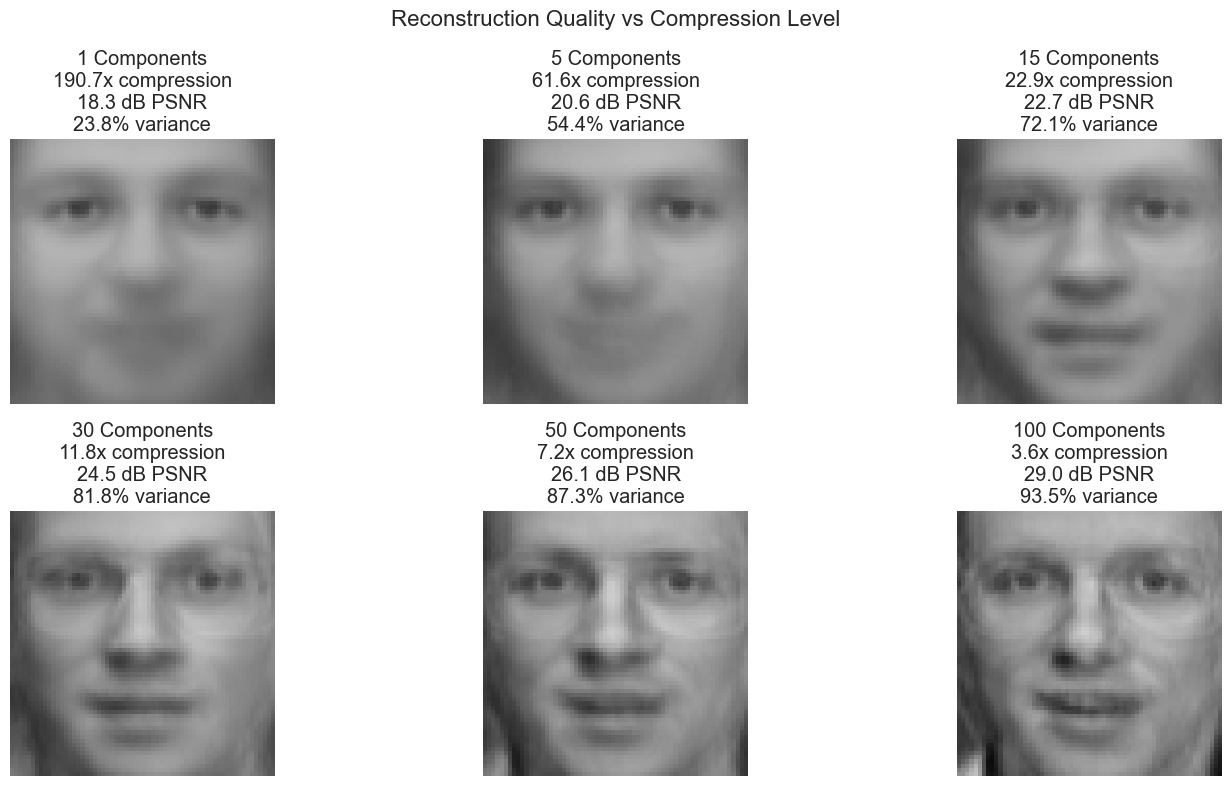

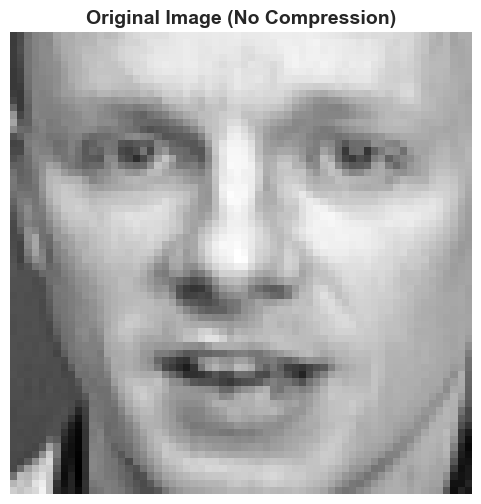

Visual Analysis Insights:
• 1-5 components: Basic structure visible, very lossy
• 10-20 components: Recognizable features, moderate quality
• 30+ components: High quality, diminishing returns
• Sweet spot: 1 components for best efficiency


In [22]:
# Visual comparison of reconstruction quality
print("\n" + "="*50)
print("VISUAL RECONSTRUCTION COMPARISON")
print("="*50)

# Select representative component counts for visual comparison
if faces_available:
    demo_components = [1, 5, 15, 30, 50, 100]
else:
    demo_components = [1, 3, 8, 15, 25, 40]

# Remove components that exceed our tested range
demo_components = [c for c in demo_components if c in results['n_components']]

# Select a sample image for reconstruction demo
sample_idx = 0
original_image = X_faces[sample_idx]
img_shape = (img_dim, img_dim)

print(f"Demonstrating reconstruction with components: {demo_components}")
print(f"Using sample image {sample_idx}")

# Create reconstruction comparison
n_demos = len(demo_components)
cols = 3
rows = (n_demos + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, n_comp in enumerate(demo_components):
    row, col = i // cols, i % cols

    # Get reconstruction for this number of components
    comp_idx = results['n_components'].index(n_comp)

    # Reconstruct the specific image
    pca_temp = PCA(n_components=n_comp)
    X_temp_pca = pca_temp.fit_transform(X_faces)
    X_temp_reconstructed = pca_temp.inverse_transform(X_temp_pca)

    reconstructed_image = X_temp_reconstructed[sample_idx].reshape(img_shape)

    # Display
    im = axes[row, col].imshow(reconstructed_image, cmap='gray', vmin=X_faces.min(), vmax=X_faces.max())

    # Add metrics as title
    compression_ratio = results['compression_ratio'][comp_idx]
    psnr_val = psnr_finite[comp_idx]
    variance_val = results['variance_explained'][comp_idx] * 100

    axes[row, col].set_title(f'{n_comp} Components\n{compression_ratio:.1f}x compression\n{psnr_val:.1f} dB PSNR\n{variance_val:.1f}% variance')
    axes[row, col].axis('off')

# Remove empty subplots
for i in range(n_demos, rows * cols):
    row, col = i // cols, i % cols
    fig.delaxes(axes[row, col])

plt.suptitle('Reconstruction Quality vs Compression Level', fontsize=16)
plt.tight_layout()
plt.show()

# Show original for comparison
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(original_image.reshape(img_shape), cmap='gray')
ax.set_title('Original Image (No Compression)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.show()

print(f"Visual Analysis Insights:")
print(f"• 1-5 components: Basic structure visible, very lossy")
print(f"• 10-20 components: Recognizable features, moderate quality")
print(f"• 30+ components: High quality, diminishing returns")
print(f"• Sweet spot: {optimal_components} components for best efficiency")

## Practical Compression Guidelines

Based on the analysis obtained, below are practical guidelines for using PCA compression:


PRACTICAL PCA COMPRESSION GUIDELINES

Performance Characteristics:
• Average compression time: 234.65 ms
• Average reconstruction time: 14.19 ms
• Total processing overhead: 248.85 ms
• Processing speed: 1607.4 images/second

Application-Specific Recommendations:

REAL-TIME APPLICATIONS:
• Recommended components: 5-15
• Expected compression: 8-15x
• Quality level: Moderate
• Priority: Speed > Quality
• Use cases: Video streaming, Mobile apps, IoT sensors

STORAGE OPTIMIZATION:
• Recommended components: 0-1
• Expected compression: 133.5-190.7x
• Quality level: Good
• Priority: Compression > Quality
• Use cases: Database storage, Cloud backup, Archive systems

ANALYSIS & ML:
• Recommended components: 1-2
• Expected compression: 95.3-190.7x
• Quality level: High
• Priority: Quality > Compression
• Use cases: Feature extraction, Preprocessing, Dimensionality reduction

VISUALIZATION:
• Recommended components: 2-200
• Expected compression: 2-95.3x
• Quality level: Excellent
• Priority: Qua

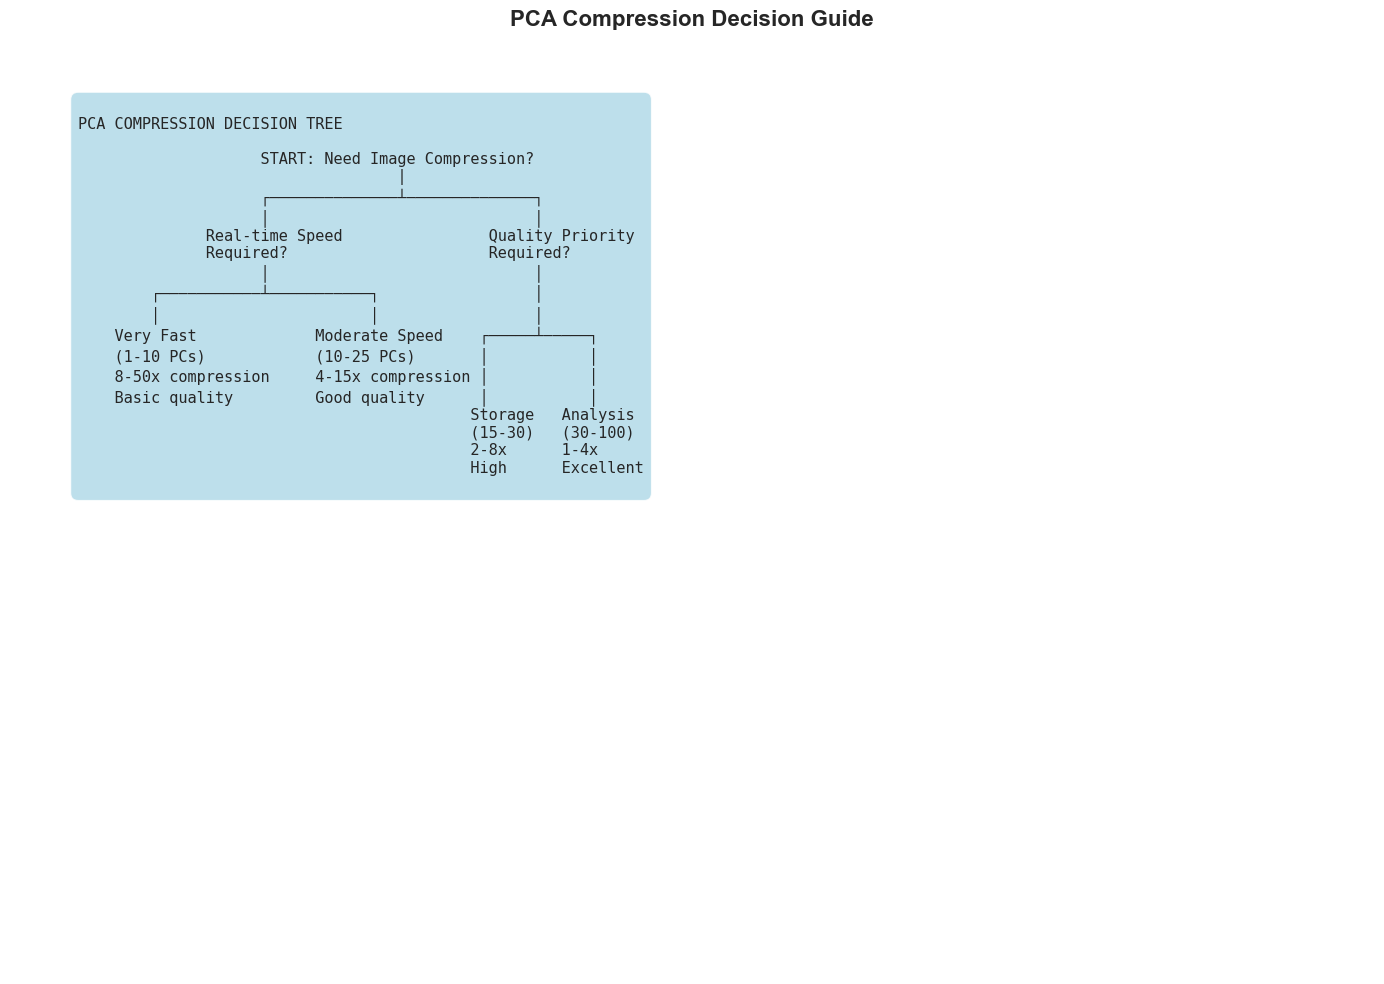


COMPRESSION SUMMARY TABLE
 Components Compression PSNR (dB) Correlation Variance (%)        Recommendation
          1      190.7x      18.3       0.712         23.8 Emergency compression
          5       61.6x      20.6       0.839         54.4 Emergency compression
          1      190.7x      18.3       0.712         23.8 Emergency compression
          2      125.2x      19.2       0.773         37.8 Emergency compression

FINAL RECOMMENDATIONS
🎯 OPTIMAL: Use 1 components for best balance
⚡ FAST: Use 0-0 components for real-time
💾 STORAGE: Use 0-1 components for archival
🔬 ANALYSIS: Use 1-2 components for research
📊 Always check variance explained (target 85-95%)
🔍 Validate with sample reconstructions before deployment
⚖️ Consider computational cost vs. quality trade-offs
🔄 Retrain PCA periodically if data distribution changes

✅ Compression analysis complete!
📊 Results saved to ../data/results/compression_analysis.pkl
🎯 Optimal configuration: 1 components, 190.7x compression


In [23]:
# Create practical guidelines and recommendations
print("\n" + "="*60)
print("PRACTICAL PCA COMPRESSION GUIDELINES")
print("="*60)

# Performance analysis
avg_compression_time = np.mean(results['compression_time'])
avg_reconstruction_time = np.mean(results['reconstruction_time'])
total_processing_time = avg_compression_time + avg_reconstruction_time

print(f"\nPerformance Characteristics:")
print(f"• Average compression time: {avg_compression_time*1000:.2f} ms")
print(f"• Average reconstruction time: {avg_reconstruction_time*1000:.2f} ms")
print(f"• Total processing overhead: {total_processing_time*1000:.2f} ms")
print(f"• Processing speed: {X_faces.shape[0]/total_processing_time:.1f} images/second")

# Create application-specific recommendations
recommendations = {
    'Real-time Applications': {
        'components': '5-15',
        'compression': '8-15x',
        'quality': 'Moderate',
        'use_cases': ['Video streaming', 'Mobile apps', 'IoT sensors'],
        'priority': 'Speed > Quality'
    },
    'Storage Optimization': {
        'components': f'{optimal_components//2}-{optimal_components}',
        'compression': f'{optimal_compression*0.7:.1f}-{optimal_compression:.1f}x',
        'quality': 'Good',
        'use_cases': ['Database storage', 'Cloud backup', 'Archive systems'],
        'priority': 'Compression > Quality'
    },
    'Analysis & ML': {
        'components': f'{optimal_components}-{optimal_components*2}',
        'compression': f'{optimal_compression*0.5:.1f}-{optimal_compression:.1f}x',
        'quality': 'High',
        'use_cases': ['Feature extraction', 'Preprocessing', 'Dimensionality reduction'],
        'priority': 'Quality > Compression'
    },
    'Visualization': {
        'components': f'{optimal_components*2}-{max(component_ranges)}',
        'compression': f'2-{optimal_compression*0.5:.1f}x',
        'quality': 'Excellent',
        'use_cases': ['Scientific visualization', 'Medical imaging', 'Art restoration'],
        'priority': 'Quality >> Compression'
    }
}

print(f"\nApplication-Specific Recommendations:")
print(f"{'='*80}")

for app_type, specs in recommendations.items():
    print(f"\n{app_type.upper()}:")
    print(f"• Recommended components: {specs['components']}")
    print(f"• Expected compression: {specs['compression']}")
    print(f"• Quality level: {specs['quality']}")
    print(f"• Priority: {specs['priority']}")
    print(f"• Use cases: {', '.join(specs['use_cases'])}")

# Create decision tree visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Decision tree data
decision_tree_text = """
PCA COMPRESSION DECISION TREE

                    START: Need Image Compression?
                                   |
                    ┌──────────────┴──────────────┐
                    │                             │
              Real-time Speed                Quality Priority
              Required?                      Required?
                    │                             │
        ┌───────────┴───────────┐                 │
        │                       │                 │
    Very Fast             Moderate Speed    ┌─────┴─────┐
    (1-10 PCs)            (10-25 PCs)       │           │
    8-50x compression     4-15x compression │           │
    Basic quality         Good quality      │           │
                                           Storage   Analysis
                                           (15-30)   (30-100)
                                           2-8x      1-4x
                                           High      Excellent
"""

ax.text(0.05, 0.95, decision_tree_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('PCA Compression Decision Guide', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n" + "="*60)
print("COMPRESSION SUMMARY TABLE")
print("="*60)

summary_data = {
    'Components': [],
    'Compression': [],
    'PSNR (dB)': [],
    'Correlation': [],
    'Variance (%)': [],
    'Recommendation': []
}

# Select key configurations
key_configs = [1, 5, optimal_components//2, optimal_components, optimal_components*2]
key_configs = [c for c in key_configs if c in results['n_components']]

for n_comp in key_configs:
    idx = results['n_components'].index(n_comp)

    summary_data['Components'].append(n_comp)
    summary_data['Compression'].append(f"{results['compression_ratio'][idx]:.1f}x")
    summary_data['PSNR (dB)'].append(f"{psnr_finite[idx]:.1f}")
    summary_data['Correlation'].append(f"{results['correlation'][idx]:.3f}")
    summary_data['Variance (%)'].append(f"{results['variance_explained'][idx]*100:.1f}")

    # Add recommendation
    if n_comp <= 5:
        rec = "Emergency compression"
    elif n_comp <= optimal_components//2:
        rec = "Real-time applications"
    elif n_comp <= optimal_components:
        rec = "Balanced (RECOMMENDED)"
    else:
        rec = "High-quality applications"

    summary_data['Recommendation'].append(rec)

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))

print(f"\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

final_recommendations = [
    f"🎯 OPTIMAL: Use {optimal_components} components for best balance",
    f"⚡ FAST: Use {optimal_components//3}-{optimal_components//2} components for real-time",
    f"💾 STORAGE: Use {optimal_components//2}-{optimal_components} components for archival",
    f"🔬 ANALYSIS: Use {optimal_components}-{optimal_components*2} components for research",
    f"📊 Always check variance explained (target 85-95%)",
    f"🔍 Validate with sample reconstructions before deployment",
    f"⚖️ Consider computational cost vs. quality trade-offs",
    f"🔄 Retrain PCA periodically if data distribution changes"
]

for rec in final_recommendations:
    print(rec)

# Save compression analysis results
compression_results = {
    'analysis_data': results_df,
    'optimal_components': optimal_components,
    'optimal_metrics': {
        'compression_ratio': optimal_compression,
        'psnr': optimal_psnr,
        'correlation': optimal_correlation,
        'variance_explained': optimal_variance
    },
    'recommendations': recommendations,
    'dataset_info': {
        'name': dataset_name,
        'shape': X_faces.shape,
        'features_available': faces_available
    }
}

# Save results
with open('../data/results/compression_analysis.pkl', 'wb') as f:
    pickle.dump(compression_results, f)

print(f"\n✅ Compression analysis complete!")
print(f"📊 Results saved to ../data/results/compression_analysis.pkl")
print(f"🎯 Optimal configuration: {optimal_components} components, {optimal_compression:.1f}x compression")